In [2]:
import json
import random
import numpy as np

# Dados dos produtos (Fardo de Latas e Engradado de Garrafas)
produtos = [
    {"id": 1, "nome": "Fardo de Latas", "volume": 0.2, "peso": 30, "valor": 150, "fragil": False },
    {"id": 2, "nome": "Engradado de Garrafas", "volume": 0.5, "peso": 20, "valor": 100, "fragil": False },
    {"id": 3, "nome": "Caixa de amendoin", "volume": 0.3, "peso": 10, "valor": 50, "fragil": True },
    {"id": 4, "nome": "Caixa de vinho", "volume": 0.3, "peso": 20, "valor": 100, "fragil": True },
    {"id": 5, "nome": "Caixa de chá gelado", "volume": 0.4, "peso": 14, "valor": 20, "fragil": True },
    {"id": 6, "nome": "Pacote de farinha de trigo", "volume": 0.6, "peso": 25, "valor": 35, "fragil": False },
]

# Gerar uma lista de 1000 produtos aleatórios
produtos_amostra = [
    {**random.choice(produtos), "id": i + 1} for i in range(900)
]

np.random.seed(42)

# Dados dos caminhões
caminhoes = [
    {"id": 1, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 2, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 3, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 4, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 5, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 6, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 7, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 8, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 9, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000},
    {"id": 10, "volume": 200, "peso": 2000, "volume_usado": 0, "peso_usado": 0, "valor_minimo": 4000}
]

# Parâmetros do Algoritmo Genético
POPULATION_SIZE = 300  # Número de soluções na população
GENERATIONS = 500  # Número de gerações
MUTATION_RATE = 0.05  # Taxa de mutação

def fitness(solution):
    valor_total = 0
    penalidade = 0

    # Resetar volume e peso usados antes de calcular a fitness
    for caminhao in caminhoes:
        caminhao["volume_usado"] = 0
        caminhao["peso_usado"] = 0

    for caminhao in caminhoes:
        volume_usado = 0
        peso_usado = 0
        possui_fragil = False
        possui_nao_fragil = False

        for produto, alocacao in zip(produtos_amostra, solution):
            if alocacao == caminhao["id"]:
                volume_usado += produto["volume"]
                peso_usado += produto["peso"]
                valor_total += produto["valor"]
                
                # Marcar a presença de produtos frágeis ou não frágeis
                if produto["fragil"]:
                    possui_fragil = True
                else:
                    possui_nao_fragil = True


        # Atualizar volume e peso usados
        caminhao["volume_usado"] += volume_usado
        caminhao["peso_usado"] += peso_usado

        # Penalidades por exceder capacidade
        if volume_usado > caminhao["volume"]:
            penalidade += (volume_usado - caminhao["volume"]) * 10
        if peso_usado > caminhao["peso"]:
            penalidade += (peso_usado - caminhao["peso"]) * 10

        valor_total = sum(produto["valor"] for produto, alocacao in zip(produtos_amostra, solution) if alocacao == caminhao["id"])
        if valor_total < caminhao["valor_minimo"]:
            penalidade += (caminhao["valor_minimo"] - valor_total) * 10
        
        # Penalidade por misturar produtos frágeis e não frágeis
        if possui_fragil and possui_nao_fragil:
            penalidade += 30  # Penalidade alta para misturas


    return valor_total - penalidade

def generate_heuristic_solution():
    solution = []
    for produto in produtos_amostra:
        allocated = False
        for caminhao in caminhoes:
            if caminhao["volume_usado"] + produto["volume"] <= caminhao["volume"] and caminhao["peso_usado"] + produto["peso"] <= caminhao["peso"]:
                solution.append(caminhao["id"])
                caminhao["volume_usado"] += produto["volume"]
                caminhao["peso_usado"] += produto["peso"]
                allocated = True
                break
        if not allocated:
            # Fallback to allocate to a random truck if no suitable truck is found
            random_truck = random.choice(caminhoes)
            solution.append(random_truck["id"])
            random_truck["volume_usado"] += produto["volume"]
            random_truck["peso_usado"] += produto["peso"]
    return solution

# Função para gerar uma solução inicial
def generate_solution():
    return [random.choice([c["id"] for c in caminhoes]) for _ in produtos_amostra]


# Função para criar a população inicial
def initialize_population():
    # return [generate_solution() for _ in range(POPULATION_SIZE)]
    return [generate_heuristic_solution() for _ in range(POPULATION_SIZE)]

# Função de seleção por torneio
def selection(population, fitness_scores):
    # total_fitness = sum(fitness_scores)
    # selection_probs = [f / total_fitness for f in fitness_scores]
    # selected = random.choices(population, weights=selection_probs, k=2)
    selected = random.choices(population, weights=fitness_scores, k=2)
    # OLD flag no streamlit - 
    return selected

# Função de cruzamento (crossover)
def crossover(parent1, parent2):
    # # JR - mudei o metodo de cruzamento para  usar Crossover de dois pontos
    # point1 = random.randint(0, len(parent1) - 1)
    # point2 = random.randint(0, len(parent1) - 1)
    # if point1 > point2:
    #     point1, point2 = point2, point1
    # child = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
    # return child
    point = random.randint(0, len(parent1) - 1)
    child = parent1[:point] + parent2[point:]
    return child
    
# Função de mutação
def mutate(solution, mutation_rate):
    if random.random() < mutation_rate:
    # Exemplo: Mutação de troca
        # index1 = random.randint(0, len(solution) - 1)
        # index2 = random.randint(0, len(solution) - 1)
        # solution[index1], solution[index2] = solution[index2], solution[index1]
    # Mutação de inversão
        # index1 = random.randint(0, len(solution) - 1)
        # index2 = random.randint(0, len(solution) - 1)
        # if index1 > index2:
        #     index1, index2 = index2, index1
        # solution[index1:index2] = reversed(solution[index1:index2])
    # Mutação de substituição
        index = random.randint(0, len(solution) - 1)
        solution[index] = random.choice([c["id"] for c in caminhoes])

# Algoritmo Genético (Treinamento)
def genetic_algorithm():
    population = initialize_population()
    mutation_rate = MUTATION_RATE
    previous_best_fitness = None

    for generation in range(GENERATIONS):
        # Avaliar a população
        fitness_scores = [fitness(sol) for sol in population]

        # Nova geração
        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = selection(population, fitness_scores)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)

            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)

            new_population.extend([child1, child2])

        population = new_population

        # Melhor solução da geração
        best_fitness = max(fitness_scores)
        
        # Atualizar a taxa de mutação dinamicamente
        if previous_best_fitness is not None and best_fitness == previous_best_fitness:
            mutation_rate = min(mutation_rate * 1.5, 0.5)  # Aumentar a taxa de mutação em até 50%, máximo de 50%
        else:
            mutation_rate = MUTATION_RATE  # Voltar ao valor original se a fitness melhorar
        
        previous_best_fitness = best_fitness
        
        print(f"Geração {generation + 1}: Melhor Fitness = {best_fitness} - Taxa de Mutação = {mutation_rate}")

    # Melhor solução final
    final_fitness_scores = [fitness(sol) for sol in population]
    best_final_solution = population[np.argmax(final_fitness_scores)]

    # Imprimir volume e peso usados por caminhão
    print("\nVolume e Peso Usados por Caminhão:")
    for caminhao in caminhoes:
        if caminhao["volume_usado"] > 0 or caminhao["peso_usado"] > 0:
            print(f"Caminhão {caminhao['id']} - Volume Usado: {caminhao['volume_usado']}m³, Peso Usado: {caminhao['peso_usado']}kg")

    # Filtrar caminhões não utilizados
    caminhoes_utilizados = [caminhao for caminhao in caminhoes if caminhao["volume_usado"] > 0 or caminhao["peso_usado"] > 0]
    print(f"\nNúmero de Caminhões Utilizados: {len(caminhoes_utilizados)}")

    return best_final_solution, max(final_fitness_scores)


In [3]:
# Executar o AG e retornar a melhor solução
best_solution, best_fitness = genetic_algorithm()
print("\nMelhor Solução Encontrada:", best_solution)
print("\nMelhor fitness:", best_fitness) # 9125


Geração 1: Melhor Fitness = 7645 - Taxa de Mutação = 0.05
Geração 2: Melhor Fitness = 7980 - Taxa de Mutação = 0.05
Geração 3: Melhor Fitness = 7575 - Taxa de Mutação = 0.05
Geração 4: Melhor Fitness = 7940 - Taxa de Mutação = 0.05
Geração 5: Melhor Fitness = 8050 - Taxa de Mutação = 0.05
Geração 6: Melhor Fitness = 8050 - Taxa de Mutação = 0.07500000000000001
Geração 7: Melhor Fitness = 7830 - Taxa de Mutação = 0.05
Geração 8: Melhor Fitness = 7835 - Taxa de Mutação = 0.05
Geração 9: Melhor Fitness = 7945 - Taxa de Mutação = 0.05
Geração 10: Melhor Fitness = 7950 - Taxa de Mutação = 0.05
Geração 11: Melhor Fitness = 8115 - Taxa de Mutação = 0.05
Geração 12: Melhor Fitness = 8005 - Taxa de Mutação = 0.05
Geração 13: Melhor Fitness = 8290 - Taxa de Mutação = 0.05
Geração 14: Melhor Fitness = 8190 - Taxa de Mutação = 0.05
Geração 15: Melhor Fitness = 7935 - Taxa de Mutação = 0.05
Geração 16: Melhor Fitness = 8235 - Taxa de Mutação = 0.05
Geração 17: Melhor Fitness = 8250 - Taxa de Mutaçã

In [4]:
import matplotlib.pyplot as plt

# Função para visualizar produtos
def visualizar_produtos():
    print("Produtos:")
    for produto in produtos_amostra:
        print(f"ID: {produto['id']}, Nome: {produto['nome']}, Volume: {produto['volume']}m³, Peso: {produto['peso']}kg, Valor: R${produto['valor']}")
    print("\n")

# Função para visualizar a alocação dos produtos
def visualizar_alocacao(solution):
    print("Alocação dos Produtos nos Caminhões:{solution}")
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        print(f"Produto {produto['nome']} (ID {produto['id']}) -> Caminhão {alocado_a_caminhao}")
    print("\n")

# Função para visualizar a carga total por caminhão (com gráfico)
def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    # Remover caminhões sem carga
    cargas_por_caminhao = {k: v for k, v in cargas_por_caminhao.items() if v['volume'] > 0 or v['peso'] > 0}
    print(f"Carga Total por Caminhão: {cargas_por_caminhao}")

    # carga por caminhão
    volumes = [cargas_por_caminhao[caminhao]['volume'] for caminhao in cargas_por_caminhao]
    pesos = [cargas_por_caminhao[caminhao]['peso'] for caminhao in cargas_por_caminhao]
    valores = [cargas_por_caminhao[caminhao]['valor'] for caminhao in cargas_por_caminhao]
    
    # % carga ocupada
    eficiencia_volume = [vol / next(c['volume'] for c in caminhoes if c['id'] == caminhao) * 100 for vol, caminhao in zip(volumes, cargas_por_caminhao)]
    eficiencia_peso = [peso / next(c['peso'] for c in caminhoes if c['id'] == caminhao) * 100 for peso, caminhao in zip(pesos, cargas_por_caminhao)]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Gráfico de volume por caminhão
    axs[0, 0].bar(cargas_por_caminhao.keys(), volumes, color='blue', alpha=0.7)
    axs[0, 0].set_title('Volume Total por Caminhão')
    axs[0, 0].set_xlabel('ID do Caminhão')
    axs[0, 0].set_ylabel('Volume (m³)')
    
    # Gráfico de peso por caminhão
    axs[0, 1].bar(cargas_por_caminhao.keys(), pesos, color='green', alpha=0.7)
    axs[0, 1].set_title('Peso Total por Caminhão')
    axs[0, 1].set_xlabel('ID do Caminhão')
    axs[0, 1].set_ylabel('Peso (kg)')

    # Gráfico de valor por caminhão
    axs[1, 0].bar(cargas_por_caminhao.keys(), valores, color='orange', alpha=0.7)
    axs[1, 0].set_title('Valor Total por Caminhão')
    axs[1, 0].set_xlabel('ID do Caminhão')
    axs[1, 0].set_ylabel('Valor (R$)')

    # Eficiência de carga (percentual de volume ocupado)
    axs[1, 1].bar(cargas_por_caminhao.keys(), eficiencia_volume, color='purple', alpha=0.7, label="Volume")
    axs[1, 1].bar(cargas_por_caminhao.keys(), eficiencia_peso, color='red', alpha=0.7, label="Peso")
    axs[1, 1].set_title('Eficiência de Carga (Volume e Peso Ocupados)')
    axs[1, 1].set_xlabel('ID do Caminhão')
    axs[1, 1].set_ylabel('Eficiência (%)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Função para calcular o valor total das cargas alocadas
def calcular_valor_total(solution):
    valor_total = 0
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                valor_total += produto['valor']
    return valor_total

Carga Total por Caminhão: {1: {'volume': 41.2, 'peso': 1998, 'valor': 7700}, 2: {'volume': 39.800000000000026, 'peso': 1870, 'valor': 6910}, 3: {'volume': 35.800000000000004, 'peso': 1765, 'valor': 6005}, 4: {'volume': 33.2, 'peso': 1686, 'valor': 6400}, 5: {'volume': 35.0, 'peso': 1672, 'valor': 6090}, 6: {'volume': 35.500000000000014, 'peso': 1720, 'valor': 6230}, 7: {'volume': 33.699999999999996, 'peso': 1606, 'valor': 5280}, 8: {'volume': 36.4, 'peso': 1865, 'valor': 6615}, 9: {'volume': 30.20000000000001, 'peso': 1688, 'valor': 6470}, 10: {'volume': 30.900000000000002, 'peso': 2001, 'valor': 9535}}


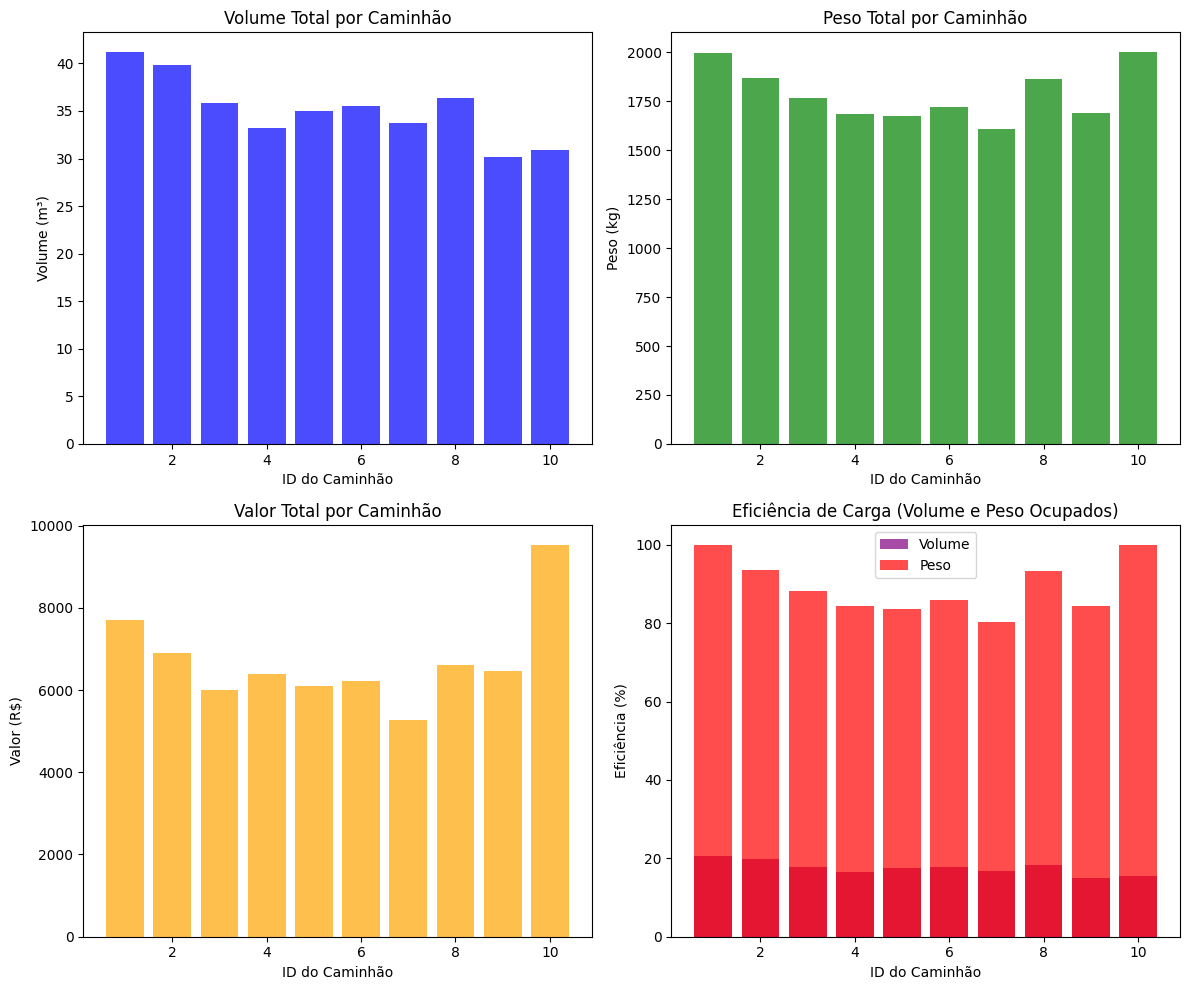

Valor Total das Cargas Alocadas: R$67235


In [5]:
# visualizar_produtos()
# visualizar_alocacao(best_solution)
visualizar_carga_por_caminhao(best_solution)
valor_total = calcular_valor_total(best_solution)

print(f"Valor Total das Cargas Alocadas: R${valor_total}")

In [6]:

def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    print("Cargas por Caminhão:")
    for caminhao in caminhoes:
        carga = cargas_por_caminhao[caminhao['id']]
        print(f"Caminhão {caminhao['id']} - Volume Total: {round(carga['volume'], 3)}m³, Peso Total: {carga['peso']}kg, Valor Total: R${carga['valor']}")
    print("\n")

visualizar_carga_por_caminhao(best_solution)

Cargas por Caminhão:
Caminhão 1 - Volume Total: 41.2m³, Peso Total: 1998kg, Valor Total: R$7700
Caminhão 2 - Volume Total: 39.8m³, Peso Total: 1870kg, Valor Total: R$6910
Caminhão 3 - Volume Total: 35.8m³, Peso Total: 1765kg, Valor Total: R$6005
Caminhão 4 - Volume Total: 33.2m³, Peso Total: 1686kg, Valor Total: R$6400
Caminhão 5 - Volume Total: 35.0m³, Peso Total: 1672kg, Valor Total: R$6090
Caminhão 6 - Volume Total: 35.5m³, Peso Total: 1720kg, Valor Total: R$6230
Caminhão 7 - Volume Total: 33.7m³, Peso Total: 1606kg, Valor Total: R$5280
Caminhão 8 - Volume Total: 36.4m³, Peso Total: 1865kg, Valor Total: R$6615
Caminhão 9 - Volume Total: 30.2m³, Peso Total: 1688kg, Valor Total: R$6470
Caminhão 10 - Volume Total: 30.9m³, Peso Total: 2001kg, Valor Total: R$9535




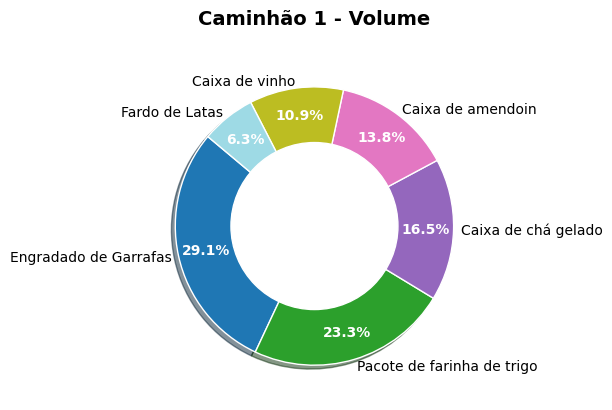

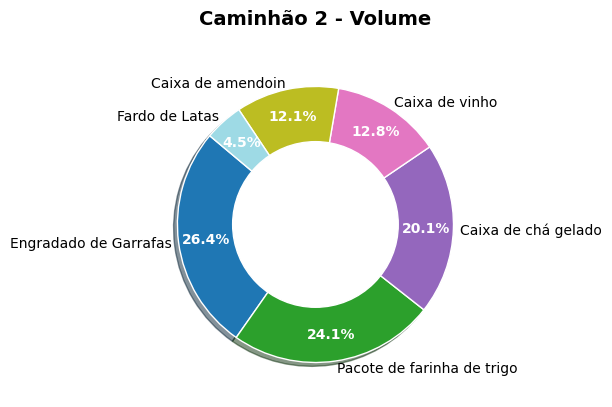

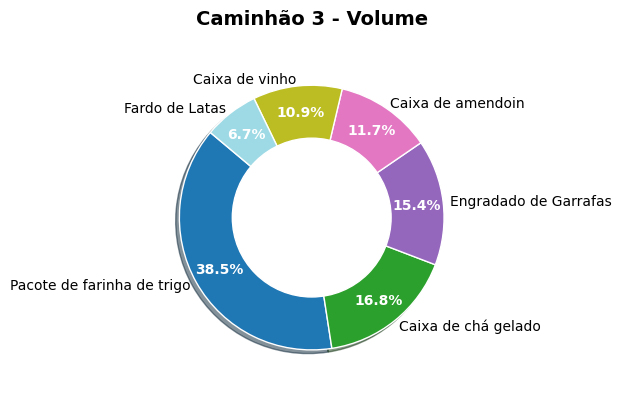

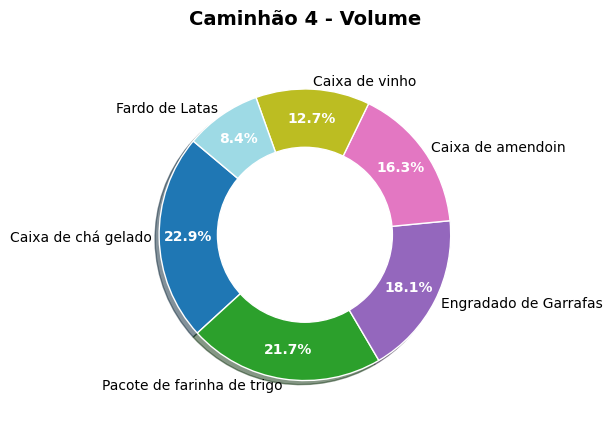

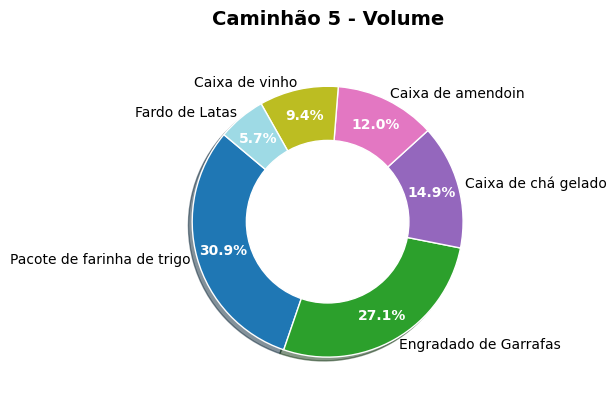

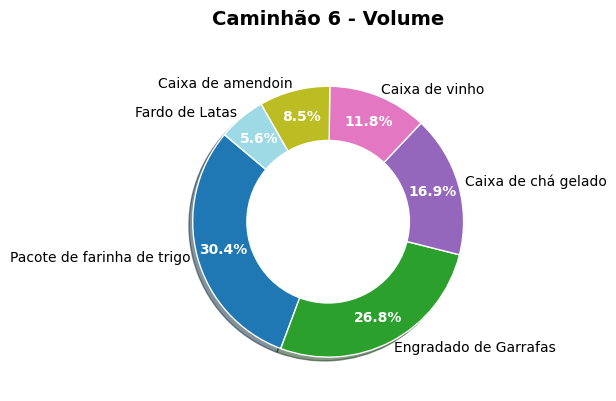

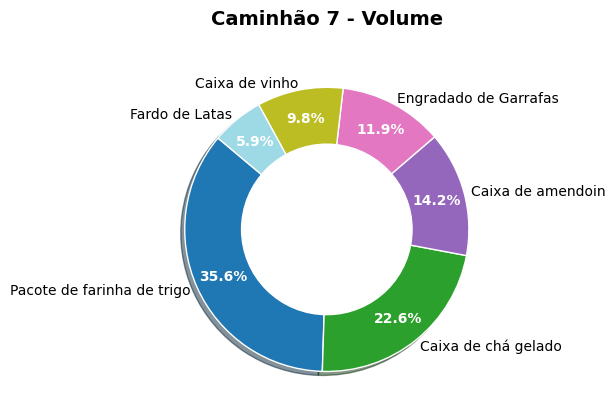

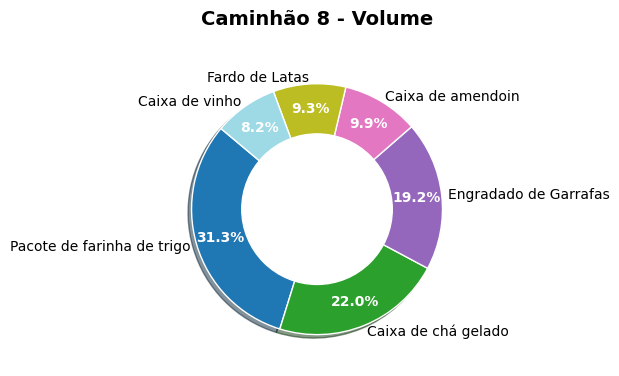

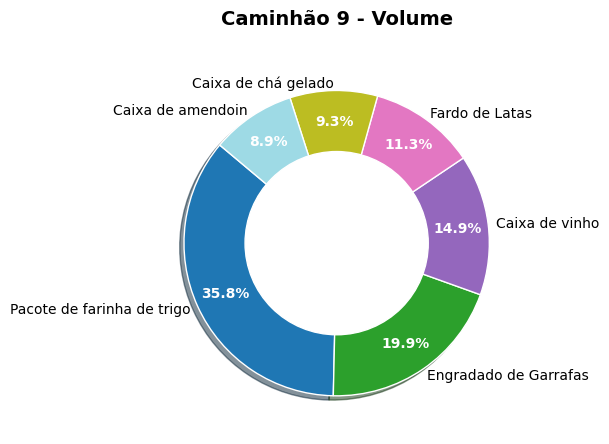

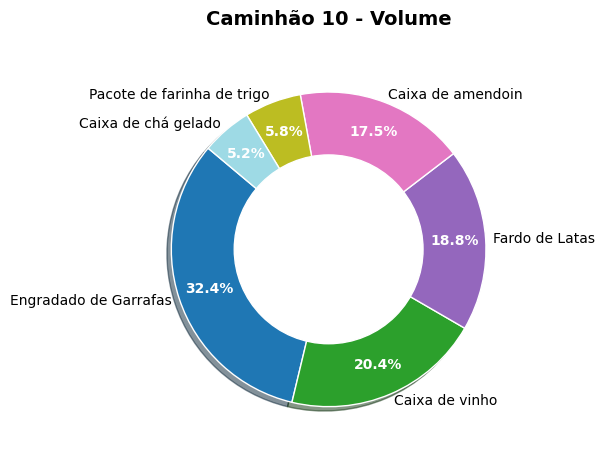

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_disco_memoria_caminhao(solution, produtos_amostra, caminhoes, caminhao_id, modo='volume', title=None, sort_slices=True, colormap='tab20'):
    # 1. Somar (volume/peso/valor) de cada tipo de produto para este caminhão
    soma_por_produto = defaultdict(float)
    
    for i, produto in enumerate(produtos_amostra):
        if solution[i] == caminhao_id:
            nome_produto = produto['nome']
            if modo == 'volume':
                soma_por_produto[nome_produto] += produto['volume']
            elif modo == 'peso':
                soma_por_produto[nome_produto] += produto['peso']
            elif modo == 'valor':
                soma_por_produto[nome_produto] += produto['valor']
            else:
                raise ValueError("O modo deve ser 'volume', 'peso' ou 'valor'.")

    # Se não há produtos nesse caminhão, apenas retorna
    if not soma_por_produto:
        print(f"Nenhum produto alocado no caminhão {caminhao_id}.")
        return

    # 2. Preparar dados para plotar
    labels = list(soma_por_produto.keys())
    valores = list(soma_por_produto.values())

    # (Opcional) Ordenar as fatias de maior para menor
    if sort_slices:
        # Organiza por valores decrescentes
        pares_ordenados = sorted(zip(labels, valores), key=lambda x: x[1], reverse=True)
        labels, valores = zip(*pares_ordenados)  # reatribui as duas listas
    
    # 3. Escolher paleta de cores
    cmap = plt.get_cmap(colormap)
    # Gerar cores diferentes para cada fatia
    # Note: Se tiver mais fatias que o colormap, você pode fazer wrap, mas normalmente tab20 tem bastante variações.
    cores = [cmap(i) for i in np.linspace(0, 1, len(labels))]

    # 4. Criar gráfico de pizza + donut (disco de memória)
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'aspect': 'equal'})

    # Parâmetros de estilo
    #  - wedgeprops para dar borda nas fatias
    #  - shadow para adicionar sombra
    wedges, texts, autotexts = ax.pie(
        valores, 
        labels=labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=cores,
        pctdistance=0.80,    # ajustar posição dos percentuais
        labeldistance=1.05,  # ajustar posição dos rótulos
        shadow=True,
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )

    # Tornar texto das porcentagens um pouco menor e em negrito (opcional)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_size(10)

    # Criar o círculo branco no meio para ter o "donut"
    donut_central = plt.Circle((0, 0), 0.60, color='white')
    ax.add_artist(donut_central)

    # 5. Título do gráfico
    if title is None:
        title = f"Caminhão {caminhao_id} - {modo.capitalize()}"
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

def plot_discos_memoria_todos_caminhoes(solution, produtos_amostra, caminhoes, modo='volume', colormap='tab20'):
    for caminhao in caminhoes:
        caminhao_id = caminhao['id']
        plot_disco_memoria_caminhao(
            solution,
            produtos_amostra,
            caminhoes,
            caminhao_id=caminhao_id,
            modo=modo,
            colormap=colormap
        )

plot_discos_memoria_todos_caminhoes(solution=best_solution, produtos_amostra=produtos_amostra, caminhoes=caminhoes)

In [8]:
# 1. Pedro - Cacular fator de penalidade - funcão 
# 2. Junior - Desenhar a curva do fitness - se der gerar frame a frame
    # Plotar um grafico com o 500 resultados gerados e (best_solution)
    # Testar com mais gerações 5 mil exemplo
# 3. Matheus - Melhor visão dos produtos alocados nos caminhões
    # Mostrar a alocação grafico em como ficou em cada caminhão.
# 4. Pedro - Criar um streamlit para poder mudar os hiper parametros(mudar as funcões)
# ultima coisa - documentar o código